<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# игнорируем warnings
import warnings
warnings.filterwarnings("ignore")

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

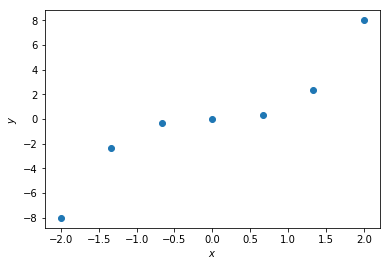

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3
 
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

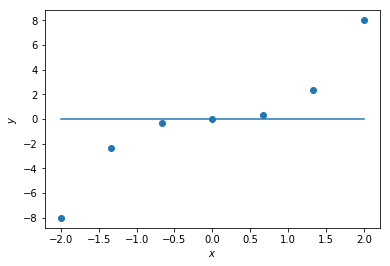

In [3]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');
plt.plot(X, [np.mean(y)] * X.shape[0]);


Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

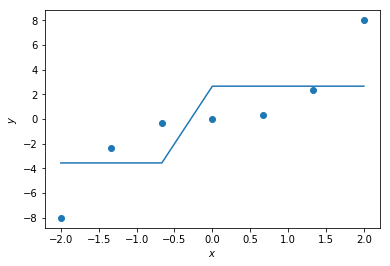

In [4]:
y_first_depth = [np.mean(y[X < 0])] * X[X < 0].shape[0] 
y_first_depth += [np.mean(y[X >= 0])] * X[X >= 0].shape[0]
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.plot(X, y_first_depth);

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def regression_var_criterion(X, y, t):
    return np.var(y) - X[X < t].shape[0] / X.shape[0] * np.var(y[X < t]) - X[X >= t].shape[0] / X.shape[0] * np.var(y[X >= t])

In [6]:
t = np.linspace(-1.9, 1.9, 50)
t

array([-1.9       , -1.82244898, -1.74489796, -1.66734694, -1.58979592,
       -1.5122449 , -1.43469388, -1.35714286, -1.27959184, -1.20204082,
       -1.1244898 , -1.04693878, -0.96938776, -0.89183673, -0.81428571,
       -0.73673469, -0.65918367, -0.58163265, -0.50408163, -0.42653061,
       -0.34897959, -0.27142857, -0.19387755, -0.11632653, -0.03877551,
        0.03877551,  0.11632653,  0.19387755,  0.27142857,  0.34897959,
        0.42653061,  0.50408163,  0.58163265,  0.65918367,  0.73673469,
        0.81428571,  0.89183673,  0.96938776,  1.04693878,  1.1244898 ,
        1.20204082,  1.27959184,  1.35714286,  1.43469388,  1.5122449 ,
        1.58979592,  1.66734694,  1.74489796,  1.82244898,  1.9       ])

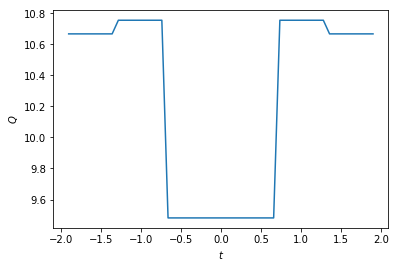

In [7]:
plt.xlabel(r'$t$')
plt.ylabel(r'$Q$')
plt.plot(t, [regression_var_criterion(X, y, t[i]) for i in range(t.shape[0])]);

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

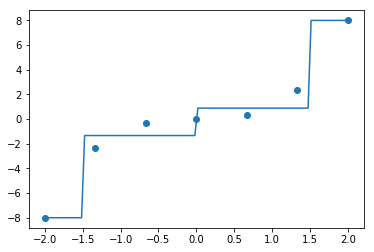

In [8]:
y_b = np.linspace(-2, 2, 100)
scale = np.linspace(-2, 2, 100)
y_b[scale < -1.5] = np.mean(y[X<-1.5])
y_b[(scale > -1.5) & (scale < 0)] = np.mean(y[(X > -1.5) & (X < 0)])
y_b[(scale >= 0) & (scale < 1.5)] = np.mean(y[(X >= 0) & (X < 1.5)])
y_b[scale > 1.5] = np.mean(y[(X > 1.5)])

plt.scatter(X, y);
plt.plot(scale, y_b);

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- <font color="green">**7**</font>
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [9]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [10]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [11]:
df['age_years'] = round(df['age']/365.25)
df = pd.get_dummies(df, columns=['cholesterol', 'gluc'])
df.drop(['age'], axis=1, inplace=True)
df.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,0,50.0,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,1,55.0,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,1,52.0,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,1,48.0,1,0,0,1,0,0
4,1,156,56.0,100,60,0,0,0,0,48.0,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [12]:
y = df['cardio']
df.drop(['cardio'], axis=1, inplace=True)

In [13]:
df.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,50.0,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,55.0,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,52.0,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,48.0,1,0,0,1,0,0
4,1,156,56.0,100,60,0,0,0,48.0,1,0,0,1,0,0


In [14]:
df.values

array([[   2.,  168.,   62., ...,    1.,    0.,    0.],
       [   1.,  156.,   85., ...,    1.,    0.,    0.],
       [   1.,  165.,   64., ...,    1.,    0.,    0.],
       ..., 
       [   2.,  183.,  105., ...,    1.,    0.,    0.],
       [   1.,  163.,   72., ...,    0.,    1.,    0.],
       [   1.,  170.,   72., ...,    1.,    0.,    0.]])

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(df.values, y, test_size=0.3, random_state=17) 

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [16]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

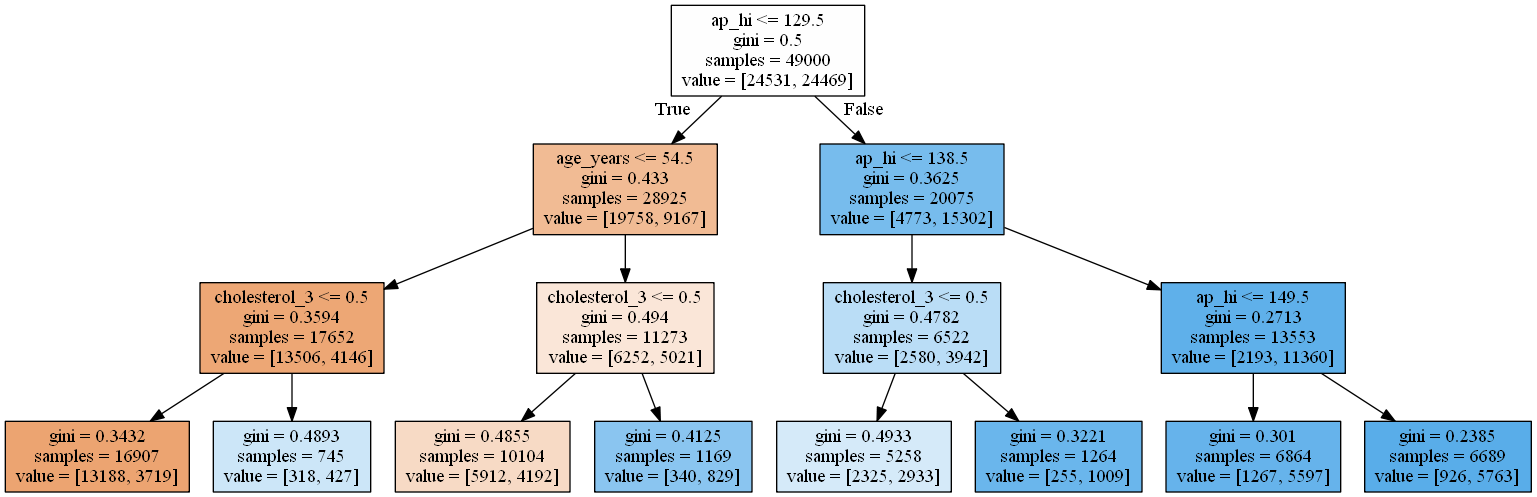

In [17]:
export_graphviz(tree, feature_names=df.columns, out_file='cardio_tree.dot', filled=True)
from IPython.display import Image
Image('cardio_tree.png')

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- **<font color="green">age, ap_hi, chol=3</font>**

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [18]:
tree_pred = tree.predict(X_valid)
acc1 = accuracy_score(y_valid, tree_pred)
acc1

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [19]:
tree_params = {'max_depth': list(range(2, 11))}
##tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5, n_jobs=-1, verbose=True)

In [20]:
%%time
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.1s finished


Wall time: 5.86 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

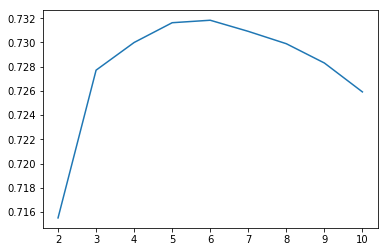

In [21]:
plt.plot(tree_grid.param_grid['max_depth'], tree_grid.cv_results_['mean_test_score']);
tree_grid

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [22]:
bA = pd.DataFrame({'max_depth': tree_grid.param_grid['max_depth'], 'mean_test_score': tree_grid.cv_results_['mean_test_score']})
i = bA['mean_test_score'].sort_values().index.tolist()[-1:]
print("Лучшее значение max_depth:", bA['max_depth'][i[0]])
print("Мах score:", tree_grid.cv_results_['mean_test_score'].max())

Лучшее значение max_depth: 6
Мах score: 0.731836734694


In [23]:
#dir(tree_grid)
tree_grid.best_params_['max_depth'], tree_grid.best_score_

(6, 0.73183673469387756)

In [586]:
acc2 = accuracy_score(y_valid, tree_grid.predict(X_valid))
print("acc2 =", acc2)
print("%.2f%%" % ((acc2 - acc1) / acc1 * 100))


acc2 = 0.726476190476
0.72%


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- **<font color="green">да, нет</font>**
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50]; age \in [50,55]; age \in [55,60]; age \in [60,65] $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- **<font color="green">Верхнее артериальное давление от 140 до 160 (мм рт.ст.)</font>**
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [28]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [29]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [30]:
df['age_years'] = round(df['age']/365.25).astype('int')
df = pd.get_dummies(df, columns=['cholesterol'])
df.drop(['age', 'height', 'weight', 'ap_lo'], axis=1, inplace=True)
df.head()

,gender,ap_hi,gluc,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,
0,2,110,1,0,0,1,0,50,1,0,0
1,1,140,1,0,0,1,1,55,0,0,1
2,1,130,1,0,0,0,1,52,0,0,1
3,2,150,1,0,0,1,1,48,1,0,0
4,1,100,1,0,0,0,0,48,1,0,0


In [31]:
df['gender'] = df['gender'].map({1:0, 2:1})
df.rename(columns={'gender': 'male'}, inplace=True)

In [32]:
df['age_years'][(df['age_years'] >= 45) & ((df['age_years'] < 50))] = 1
df['age_years'][(df['age_years'] >= 50) & ((df['age_years'] < 55))] = 2
df['age_years'][(df['age_years'] >= 55) & ((df['age_years'] < 60))] = 3
df['age_years'][(df['age_years'] >= 60) & ((df['age_years'] <= 65))] = 4
df['age_years'][(df['age_years'] > 4)] = 0
df = pd.get_dummies(df, columns=['age_years'])

In [33]:
df['ap_hi'][df['ap_hi'] < 120] = 0
df['ap_hi'][df['ap_hi'] > 180] = 0

df['ap_hi'][(df['ap_hi'] >= 120) & ((df['ap_hi'] < 140))] = 1
df['ap_hi'][(df['ap_hi'] >= 140) & ((df['ap_hi'] < 160))] = 2
df['ap_hi'][(df['ap_hi'] >= 160) & ((df['ap_hi'] <= 180))] = 3
df = pd.get_dummies(df, columns=['ap_hi'])

In [34]:
y = df['cardio']
df.drop(['cardio'], axis=1, inplace=True)
df.head()

,male,gluc,smoke,alco,active,cholesterol_1,cholesterol_2,cholesterol_3,age_years_0,age_years_1,age_years_2,age_years_3,age_years_4,ap_hi_0,ap_hi_1,ap_hi_2,ap_hi_3
id,,,,,,,,,,,,,,,,,
0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0
1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0
2,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
3,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(df.values, y, test_size=0.3, random_state=17)

In [36]:
%%time
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

Wall time: 53.6 ms


In [37]:
tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [40]:
export_graphviz(tree, feature_names=df.columns, out_file='cardio_tree2.dot', filled=True)
!dot -Tpng "cardio_tree2.dot" -o "cardio_tree2.png"

In [41]:
!ls *.dot

cardio_tree.dot
cardio_tree2.dot
telecom_tree.dot


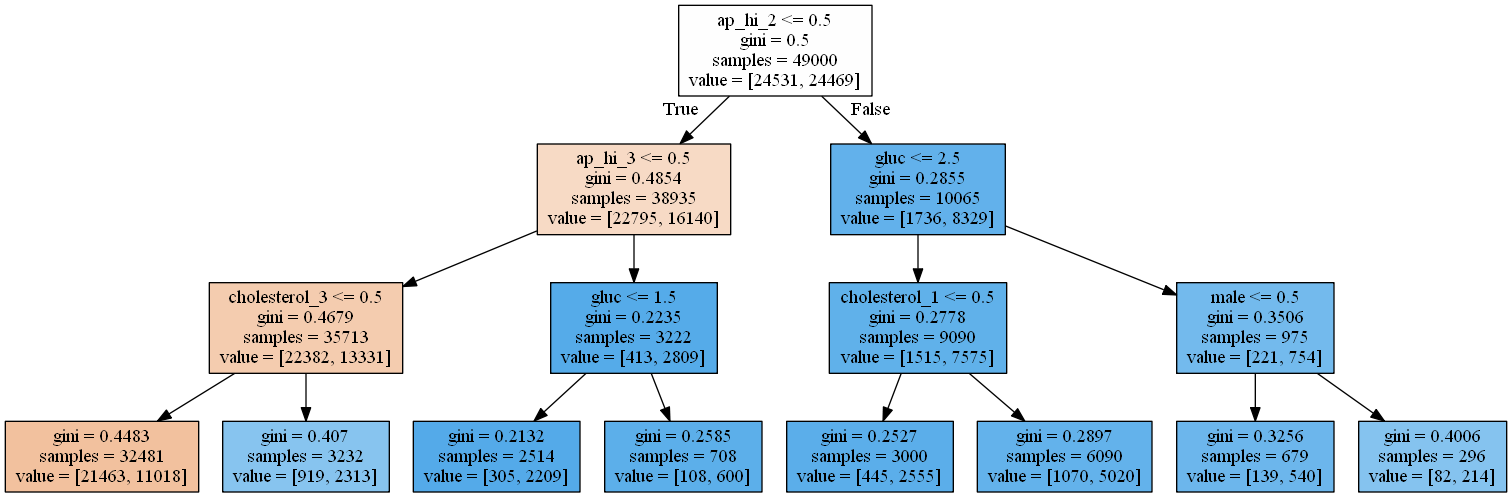

In [42]:
from IPython.display import Image
Image('cardio_tree2.png')

In [43]:
tree_pred = tree.predict(X_valid)
acc1 = accuracy_score(y_valid, tree_pred)
acc1

0.70990476190476193